In [41]:
import pandas as pd 
import wandb
import numpy as np
from matplotlib import pyplot as plt

api = wandb.Api()
entity, project = "guneytombak", "aniso_sgdn"  # set to your entity and project 
runs = api.runs(entity + "/" + project) 

In [42]:
def get_size(cfg):
    if isinstance(cfg['hidden_size'], int):
        return 1
    else:
        return len(cfg['hidden_size'])

def get_dname(cfg):
    if isinstance(cfg['dataset_name'], dict):
        return 'gen'
    else: 
        return str(cfg['dataset_name']).split('.')[1].lower()

def get_config(run):
    c = dict()
    # hidden size
    c['hsize'] = get_size(run.config)
    # dataset name
    c['dname'] = get_dname(run.config)
    # activation type
    c['activ'] = str(run.config['activ_type']).split('.')[1].lower()
    # learning / random
    c['learn'] = True if run.name[-10] == 'l' else False

    return c

def consistency_check(run):
    data = np.array(run.history()[['Lower', 'EoSq', 'Upper']])
    data = data[~np.isnan(data).any(axis=1)]
    l, t, u = data[:,0], data[:,1], data[:,2]
    return np.sum(l > t), np.sum(t > u)

def ratio_ul(run):
    data = np.array(run.history()[['Lower', 'EoSq', 'Upper']])
    data = data[~np.isnan(data).any(axis=1)]
    l, t, u = data[:,0], data[:,1], data[:,2] 
    lot, uot = l/t, u/t
    return lot, uot

def find_params(run, rel=['Loss', 'EoSq']):

    data = np.array(run.history()[rel])
    data = data[~np.isnan(data).any(axis=1)]
    x, y = data[:,0], data[:,1]

    rho = np.corrcoef(x,y)[0,1]

    logA = np.vstack([np.log(x), np.ones(len(x))]).T
    p, _ = np.linalg.lstsq(logA, np.log(y), rcond=None)[0]

    # y = a*x**p + b
    # log(y-b) = log(a) + p*log(x)

    """
    b = 0.0
    for k in range(1):
        
        Ap = np.vstack([x**p, np.ones(len(x))]).T
        a, b = np.linalg.lstsq(Ap, y, rcond=None)[0]
        y_pred = a*(x**p) + b
    """
    
    return rho, p


In [43]:
result_data = list()

for run in runs: 
    if 'final' in run.TAGS and run.state == 'finished':
        data_dict = get_config(run)
        data_dict['lv'], data_dict['uv'] = consistency_check(run)
        lot, uot = ratio_ul(run)
        data_dict['lot_mean'], data_dict['lot_max'], data_dict['lot_min'] = np.mean(lot), np.max(lot), np.min(lot)
        data_dict['uot_mean'], data_dict['uot_max'], data_dict['uot_min'] = np.mean(uot), np.max(uot), np.min(uot)
        data_dict['rho'], data_dict['exp'] = find_params(run, ['Loss', 'EoSq'])
        data_dict['rho2'], data_dict['exp2'] = find_params(run, ['Lower', 'EoSq'])
        data_dict['rho3'], data_dict['exp3'] = find_params(run, ['Loss', 'Lower'])
        result_data.append(data_dict)
            
df = pd.DataFrame(result_data)

In [49]:
def summarize_df(df, coefs, analylist=['mean', 'std']):
    if not isinstance(coefs,list):
        coefs = [coefs]
    data = list()
    dnames = ['energy', 'gen', 'grid', 'house']
    hsizes = [1, 2, 3]
    activs = ['relu', 'sigmoid', 'gelu']
    learns = [True, False]
    for dn in dnames:
        for hs in hsizes:
            for ac in activs:
                for lr in learns:
                    run = {'dname'  : dn,
                           'hsize'  : hs,
                           'activ'  : ac,
                           'learn'  : lr}
                    df_i = \
                    df[(df['dname']==dn) & (df['hsize']==hs) & \
                       (df['activ']==ac) & (df['learn']==lr)]

                    if len(df_i) == 0:
                        continue

                    for coef in coefs: 
                        if 'mean' in analylist:
                            run[coef+'_mean'] = np.mean(np.array(df_i[coef]))
                        if 'std' in analylist:
                            if len(df_i) == 1:
                                run[coef+'_std'] = 0.0
                            else:
                                run[coef+'_std'] = np.std(np.array(df_i[coef]))
                        if 'max' in analylist:
                            run[coef+'_max'] = np.max(np.array(df_i[coef]))
                        if 'min' in analylist:
                            run[coef+'_min'] = np.max(np.array(df_i[coef]))

                    run['num'] = len(df_i)

                    data.append(run)

    return pd.DataFrame(data)

In [125]:
plt.rcParams['text.usetex'] = True

def get_marker(activ):
    if activ == 'relu':
        return 's'
    if activ == 'gelu':
        return 'd'
    if activ == 'sigmoid':
        return 'o'

def plot_coef(dfs, dname, coef, ax=None, clr='blue', s=5.0):
    plt_df = dfs[dfs['dname'] == dname].reset_index()
    x = np.array(4*s*plt_df['hsize'] - 1.0*s)
    x[np.array(plt_df['activ']=='relu')] = x[np.array(plt_df['activ']=='relu')] - 1.0*s
    x[np.array(plt_df['activ']=='gelu')] = x[np.array(plt_df['activ']=='gelu')] + 1.0*s
    x[np.array(plt_df['learn']==True)] = x[np.array(plt_df['learn']==True)] - 0.20*s
    x[np.array(plt_df['learn']==False)] = x[np.array(plt_df['learn']==False)] + 0.20*s

    mean_data, std_data = plt_df[coef + '_mean'], plt_df[coef + '_std']

    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)

    for k in range(len(x)):
        mk = get_marker(plt_df['activ'][k])
        mk = 's' if plt_df['learn'][k] else 'o'
        ax.errorbar(x[k], mean_data[k], yerr=std_data[k], ls='',
                    markersize=2, marker=mk, color=clr, alpha=0.7)

    return ax, x
    
    

0

In [126]:
df_rho = summarize_df(df, ['rho', 'rho2', 'rho3'])
df_lot = summarize_df(df, ['lot_mean'])
df_uot = summarize_df(df, ['uot_mean'])

In [65]:
df_uot

,dname,hsize,activ,learn,uot_mean_mean,num
0,energy,1,relu,True,4.692501,3
1,energy,1,relu,False,4.170716,3
2,energy,1,sigmoid,True,2.195561,3
3,energy,1,sigmoid,False,2.569637,3
4,energy,1,gelu,True,5.365870,3
5,energy,1,gelu,False,4.214091,3
6,energy,2,relu,True,4.338430,3
7,energy,2,relu,False,4.346573,3
8,energy,2,sigmoid,True,1.958213,3
9,energy,2,sigmoid,False,2.847297,3


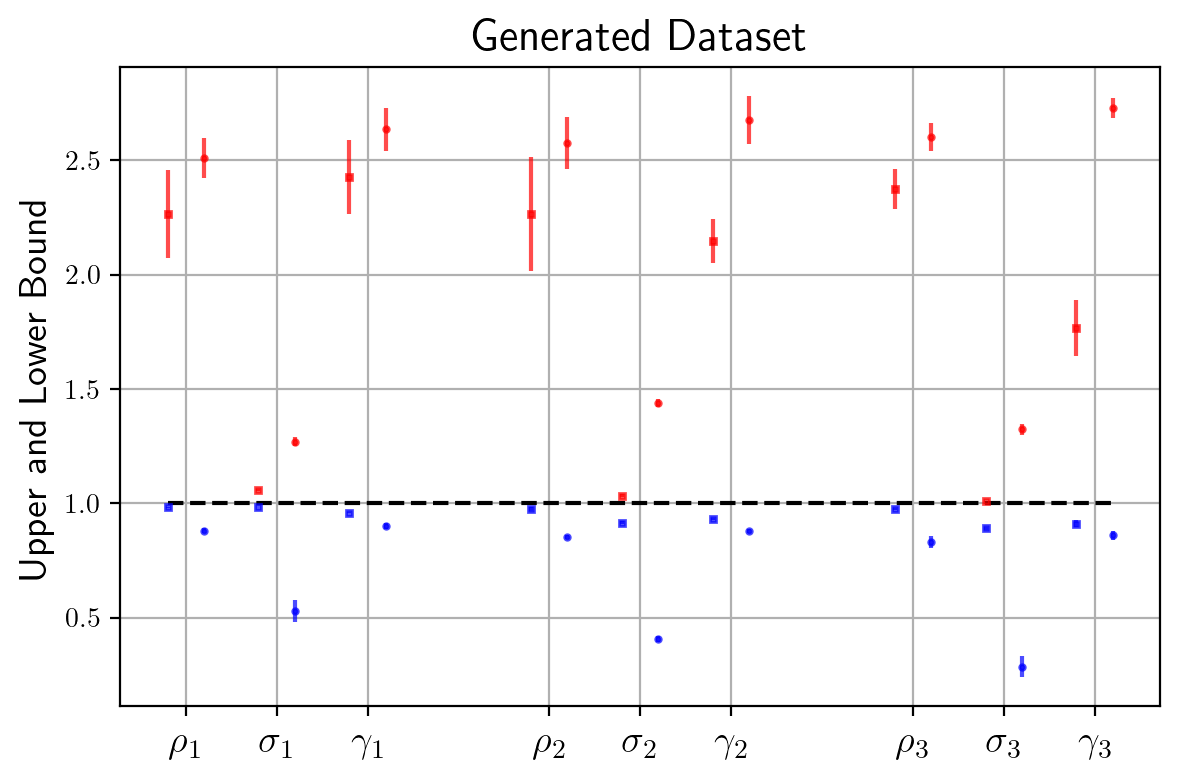

In [139]:
dname = 'gen'
dname_title = 'Generated Dataset'

fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
fig.set_dpi(200)
ax, x = plot_coef(df_lot, dname, 'lot_mean', ax=ax, clr='blue') # Loss vs EoSq
ax, x = plot_coef(df_uot, dname, 'uot_mean', ax=ax, clr='red') # Lower vs EoSq
#ax, x = plot_coef(df_rho, dname, 'rho3', ax=ax, clr='green') # Loss vs Lower

xm = np.mean(x.reshape([-1,2]),1)
rsg1 = [r'$\rho_1$', r'$\sigma_1$', r'$\gamma_1$']
rsg2 = [r'$\rho_2$', r'$\sigma_2$', r'$\gamma_2$']
rsg3 = [r'$\rho_3$', r'$\sigma_3$', r'$\gamma_3$']

ax.set_ylabel('Upper and Lower Bound', size=14)
plt.xticks(xm, [*rsg1, *rsg2, *rsg3], size=14) 
ax.set_title(dname_title, size=16)
ax.hlines(1.0, min(x), max(x), linestyles='dashed', colors='k')
plt.grid()
plt.show()

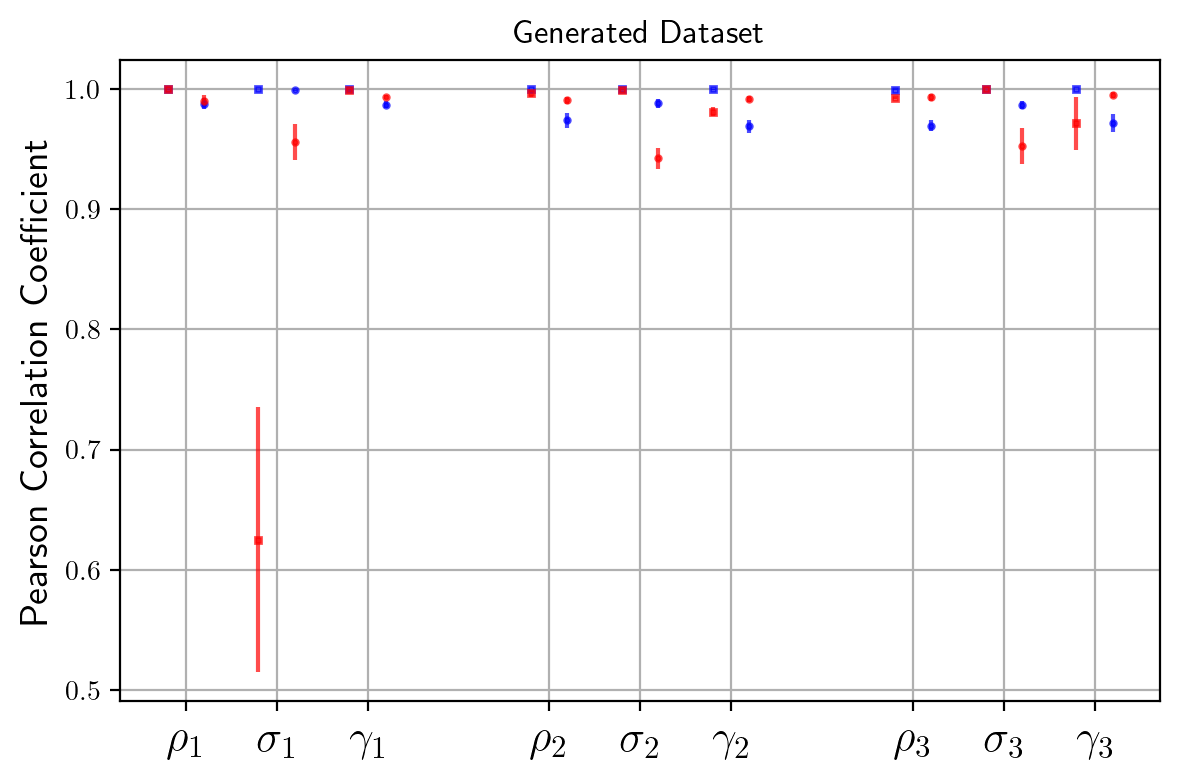

,dname,hsize,activ,learn,rho_mean,rho_std,rho2_mean,rho2_std,rho3_mean,rho3_std,num
0,energy,1,relu,True,0.999372,1.320435e-04,0.998454,0.000475,0.997627,0.000342,3
1,energy,1,relu,False,0.988514,2.748238e-03,0.997917,0.000844,0.983279,0.003391,3
2,energy,1,sigmoid,True,0.999982,1.181757e-05,0.991123,0.008206,0.993941,0.008480,3
3,energy,1,sigmoid,False,0.998856,3.447343e-04,0.979955,0.008315,0.976882,0.008852,3
4,energy,1,gelu,True,0.998333,8.010198e-04,0.997300,0.000820,0.991806,0.000911,3
5,energy,1,gelu,False,0.986623,3.028156e-03,0.998292,0.000728,0.981258,0.004314,3
6,energy,2,relu,True,0.994691,3.491885e-03,0.999576,0.000213,0.992168,0.005089,3
7,energy,2,relu,False,0.968705,6.345818e-03,0.996363,0.001327,0.958948,0.004143,3
8,energy,2,sigmoid,True,0.986403,4.661057e-03,0.997034,0.002926,0.982767,0.008313,3
9,energy,2,sigmoid,False,0.966551,1.248193e-02,0.908747,0.008401,0.837575,0.041055,3


In [114]:
dname = 'gen'
dname_title = 'Generated Dataset'

fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
fig.set_dpi(200)
ax, x = plot_coef(df_rho, dname, 'rho', ax=ax, clr='blue') # Loss vs EoSq
ax, x = plot_coef(df_rho, dname, 'rho2', ax=ax, clr='red') # Lower vs EoSq
#ax, x = plot_coef(df_rho, dname, 'rho3', ax=ax, clr='green') # Loss vs Lower

xm = np.mean(x.reshape([-1,2]),1)
rsg1 = [r'$\rho_1$', r'$\sigma_1$', r'$\gamma_1$']
rsg2 = [r'$\rho_2$', r'$\sigma_2$', r'$\gamma_2$']
rsg3 = [r'$\rho_3$', r'$\sigma_3$', r'$\gamma_3$']

ax.set_ylabel('Pearson Correlation Coefficient', size=14)
plt.xticks(xm, [*rsg1, *rsg2, *rsg3], size=16) 
ax.set_title(dname_title)
plt.grid()
plt.show()